# Разведывательный анализ данных. Часть 1

В этой части анализа сделаем разведовательный анализ данных. Рассмотрим каждую таблицу. Попробуем объединить некоторые таблицы и сделать общий анализ и выводы по исходным данным. Давайте рассмотрим задачу:

**Описание задачи**

В группе компаний Тинькофф есть команда edTech, создающая платформу для обучающих курсов.
У команды edTech возникает вопрос, а какие курсы сильнее всего влияют на рабочие показатели сотрудников в колл-центре.
Помогите составить рекомендации, какие обучающие курсы стоит проходить сотрудникам, а какие курсы стоит убрать с edTech платформы.
Решение может быть как рекомендательной моделью для каждого из сотрудников, так и основано на бизнес-правилах и статистическом анализе (например, выделить для каждого департамента полезные курсы).

**Потенциальное решение**

Предполагается, что решение будет выполнено на Python, будет итоговая презентация. Решение может содержать блоки: эксплораторный анализ, Causal Inference методы, рекомендательную модель.
Ограничений на подход к решению нет, но для определения важности курсов советуем использовать методы анализа причинности. Подробнее можно почитать о них [здесь,](https://koch-kir.medium.com/causal-inference-from-observational-data-%D0%B8%D0%BB%D0%B8-%D0%BA%D0%B0%D0%BA-%D0%BF%D1%80%D0%BE%D0%B2%D0%B5%D1%81%D1%82%D0%B8-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82-%D0%B1%D0%B5%D0%B7-%D0%B0-%D0%B2-%D1%82%D0%B5%D1%81%D1%82%D0%B0-afb84f2579f2) а также возможна консультация со стороны организаторов.

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# Установка опции для отображения нормальных чисел
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Анализ таблицы Communications

**communications**

Информация о рабочих показателях сотрудников. Рассматривались рабочие коммункации операторов колл-центра
Поля:
- communication_id – идентификатор коммуникации
- communication_dt – дата коммуникации
- employee_id - идентификатор сотрудника
- communication_score – оценка качества коммуникации
- util_flg – флаг того, что клиент воспользовался банковским продуктом в течение 2 недель

In [4]:
# Загрузим датасет
communications = pd.read_csv('../data/src/communications.csv', sep=';', dtype={'employee_id': 'category'})

# Измененим типов данных некоторых столбцов
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])

In [5]:
# Рассмотрим первые 5 строк датасета
communications.head(5)

,communication_id,communication_dt,employee_id,communication_score,util_flg
0,177074281189583840,2023-02-07,269d837a-fada-308d-d4ae-ab28ca2d57e4,85,0
1,189925315406757324,2023-07-29,e6384711-4917-13d2-9bc6-3fc5eeb5ba4f,100,0
2,321818238739717242,2023-09-06,ab541d87-4c7b-c19a-b776-42849e02b89f,43,1
3,192259329962028989,2023-06-19,0a0a0c8a-aa00-ade5-0f74-a3f0ca981ed7,100,1
4,705274671052151857,2023-08-11,f93882cb-d8fc-7fb7-94c1-011d63be6fb6,46,0


In [6]:
# Рассмотрим информацию о датасете
communications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 5 columns):
 #   Column               Dtype         
---  ------               -----         
 0   communication_id     int64         
 1   communication_dt     datetime64[ns]
 2   employee_id          category      
 3   communication_score  int64         
 4   util_flg             int64         
dtypes: category(1), datetime64[ns](1), int64(3)
memory usage: 173.4 MB


In [7]:
# Напишем функцию для построения графика для определения выбросов
def boxplot_all(xSize, ySize, palette, data):
    """
    Эта функция создает boxplot для каждой переменной в DataFrame.
    
    Параметры:
    xSize (int): Ширина области графика.
    ySize (int): Высота области графика.
    palette (str): Название цветовой палитры для использования в графике.
    data (DataFrame): Данные Pandas DataFrame, для которых строится boxplot.
    
    Возвращает:
    Матрицу графиков с boxplot для каждой переменной в DataFrame.
    """
    # Создаем подграфик с заданными размерами
    f, axes = plt.subplots(1, 1, figsize=(xSize, ySize))
    
    # Преобразуем DataFrame для отображения переменных в столбцах и их значений в строках
    melted_data = pd.melt(data)
    
    # Строим boxplot с использованием seaborn для всех переменных в DataFrame
    plot = sns.boxplot(x='variable',y='value', data=melted_data, palette=palette, ax=axes, orient='v')
    
    # Удаляем подпись оси X, поскольку она не требуется
    plot.set_xlabel('',fontsize=20)
    
    # Устанавливаем параметры для подписей категорий на оси X
    plot.set_xticklabels(rotation=60, labels=plot.get_xticklabels(), fontweight='demibold', fontsize='x-large')


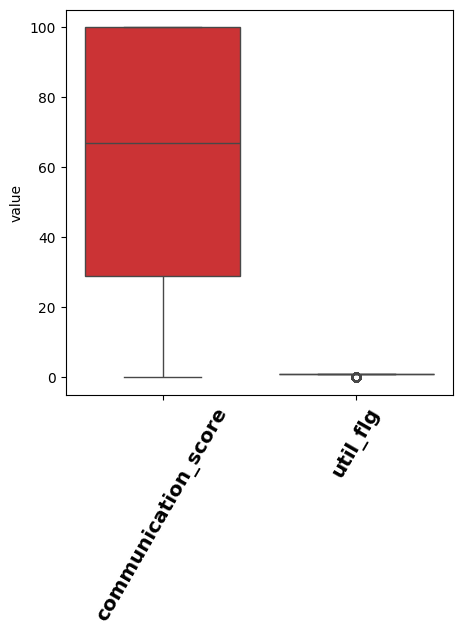

In [8]:
# Построим графики
boxplot_all(5, 5, palette='Set1', data=communications.iloc[:, 3:5])

**Оценка коммуникации (communication_score):**
- Распределение оценок качества коммуникации сосредоточено в верхней части шкалы, что указывает на высокие оценки в большинстве случаев.
- Медиана оценок качества коммуникации превышает средний уровень.
- Присутствуют выбросы с очень низкой оценкой качества коммуникации, однако их количество ограничено.
- Верхняя граница "ящика" (75-й процентиль) находится на максимальном значении оценки (100 баллов), что говорит о значительном количестве высоких оценок.

**Использование продукта (util_flg):**
- Переменная показывает два уникальных значения, что соответствует её бинарной природе.

In [9]:
# Расмотрим основные характеристики
communications.describe(include='all')

,communication_id,communication_dt,employee_id,communication_score,util_flg
count,5345246.00,5345246,5345246,5345246.00,5345246.00
unique,NaN,NaN,2381,NaN,NaN
top,NaN,NaN,a07c2f3b-3b90-7aaf-8436-a26c6d77f0a2,NaN,NaN
freq,NaN,NaN,3214,NaN,NaN
mean,500199033041779136.00,2023-07-10 13:44:39.334123776,NaN,58.56,0.75
min,1052382138.00,2023-01-01 00:00:00,NaN,0.00,0.00
25%,243720040218200704.00,2023-04-28 00:00:00,NaN,29.00,1.00
50%,500446782549360256.00,2023-07-17 00:00:00,NaN,67.00,1.00
75%,756578332801364992.00,2023-09-23 00:00:00,NaN,100.00,1.00
max,999999791018721664.00,2023-12-20 00:00:00,NaN,100.00,1.00


**Основные метрики:**
- **Количество записей**: В датасете присутствует 5,345,246 записей о коммуникациях.
- **Количество уникальных дней**: В данных присутствуют коммуникации на протяжении 354 дней.
- **Количество сотрудников**: В данных упоминается 2 381 уникальный сотрудник.
- **Самая активная дата коммуникаций**: Наиболее активным днем для коммуникаций был `2023-12-16`, в течение которого было зарегистрировано 22 680 коммуникаций. Видимо сказалось предновогоднее время.
- **Самый активный сотрудник**: Сотрудник с идентификатором `a07c2f3b-3b90-7aaf-8436-a26c6d77f0a2` был наиболее активным, сделав 3 214 коммуникаций за этот период.

**Статистики оценок коммуникации (`communication_score`):**
- **Средняя оценка**: Средняя оценка коммуникации составила 58.56, что может свидетельствовать о достаточно высоком качестве коммуникаций в целом.
- **Стандартное отклонение**: Стандартное отклонение оценок равно 37.08, что указывает на значительную вариативность в оценках качества коммуникации.
- **Минимальная оценка**: Наименьшая зарегистрированная оценка составила 0.
- **Максимальная оценка**: Максимальная оценка достигла 100, что является пределом шкалы оценки.
- **Медиана**: Медианное значение оценок составило 67, что выше среднего, указывая на то, что более половины оценок находятся выше среднего уровня.
- **Первый квартиль**: 25% оценок находятся ниже 29, что говорит о наличии значительного количества низких оценок.
- **Третий квартиль**: 75% оценок ниже 100, что свидетельствует о широком размахе оценок, но при этом 25% составляет оценку 100.

**Использование продукта (`util_flg`):**
- **Средний показатель использования**: В среднем, 75% коммуникаций заканчиваются тем, что клиенты воспользовались продуктом в течение 2 недель после коммуникации, что свидетельствует о высокой эффективности коммуникаций.
- **Стандартное отклонение**: Стандартное отклонение равно 0.43, что указывает на вариативность в успешности коммуникаций между различными сотрудниками или в разные периоды.
- **Минимальное и максимальное значения**: Минимальное значение равно 0 (клиент не воспользовался продуктом), а максимальное – 1 (клиент воспользовался продуктом), что подтверждает бинарную природу этого показателя.

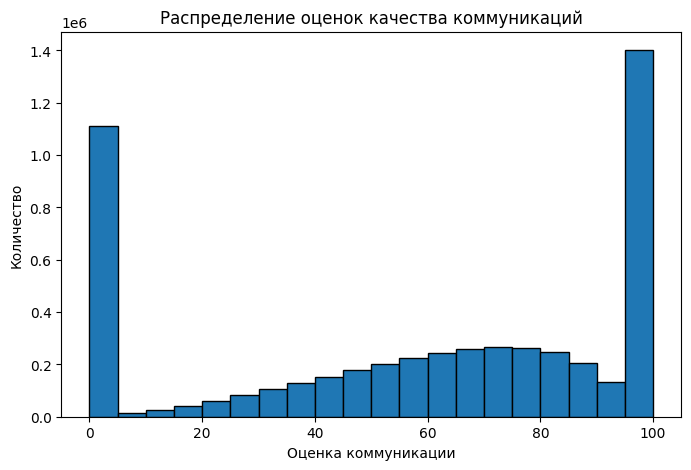

In [10]:
# Распределение оценок коммуникации
# Создание гистограммы для 'communication_score'
plt.figure(figsize=(8, 5))  # Устанавливаем размер фигуры

# Строим гистограмму
plt.hist(communications['communication_score'], bins=20, edgecolor='black')

# Добавляем название графика и подписи осей
plt.title('Распределение оценок качества коммуникаций')
plt.xlabel('Оценка коммуникации')
plt.ylabel('Количество')

# Показываем график
plt.show()

**Выводы по графику:**
- Распределение с двумя пиками: На графике видны два ярко выраженных пика – один около нулевой отметки и другой в районе максимальной оценки 100. Это указывает на бимодальное распределение оценок.
- Большое количество высоких оценок: Существует значительное количество коммуникаций, оцененных на максимально возможный балл, что может свидетельствовать о высоком качестве коммуникационных навыков сотрудников или возможной щедрости в оценках.
- Наличие нулевых оценок: Заметное количество коммуникаций оценено в ноль, что требует дополнительного анализа, так как это может указывать на проблемы в процессе коммуникации или на ошибки в данных.
- Редкие средние оценки: Между двумя пиками на графике оценки распределены относительно равномерно, но их количество существенно меньше по сравнению с крайностями. Это может указывать на то, что в процессе оценки коммуникаций редко присваиваются средние значения, либо оценки склонны к крайностям.

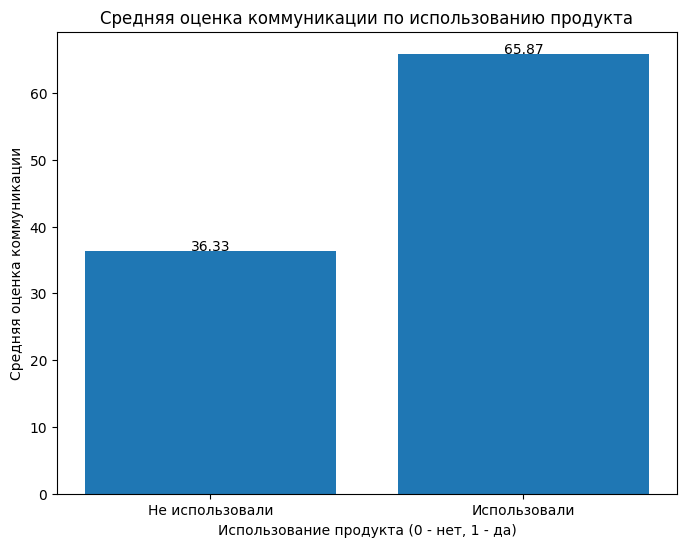

In [11]:
# Группировка данных и вычисление средних значений
mean_scores = communications.groupby('util_flg', as_index=False)['communication_score'].mean()

# Создание графика
plt.figure(figsize=(8, 6))

# Построение столбчатой диаграммы
plt.bar(mean_scores['util_flg'], mean_scores['communication_score'], 
        tick_label=['Не использовали', 'Использовали'])

# Добавление текста средних значений над столбцами
for i, score in enumerate(mean_scores['communication_score']):
    plt.text(i, score + 0.05, f'{score:.2f}', ha='center')

# Настройка заголовка и осей
plt.title('Средняя оценка коммуникации по использованию продукта')
plt.xlabel('Использование продукта (0 - нет, 1 - да)')
plt.ylabel('Средняя оценка коммуникации')

# Отображение графика
plt.show()

- **Не использовали продукт**: Средняя оценка коммуникаций клиентов, которые не использовали продукт, составляет 36.33. Это относительно низкая оценка, что может указывать на то, что низкое качество коммуникации могло повлиять на их решение не использовать продукт.
- **Использовали продукт**: Средняя оценка коммуникаций клиентов, которые использовали продукт, значительно выше и составляет 65.87. Это говорит о том, что более качественные коммуникации могут быть связаны с более высокой вероятностью использования продукта клиентами.

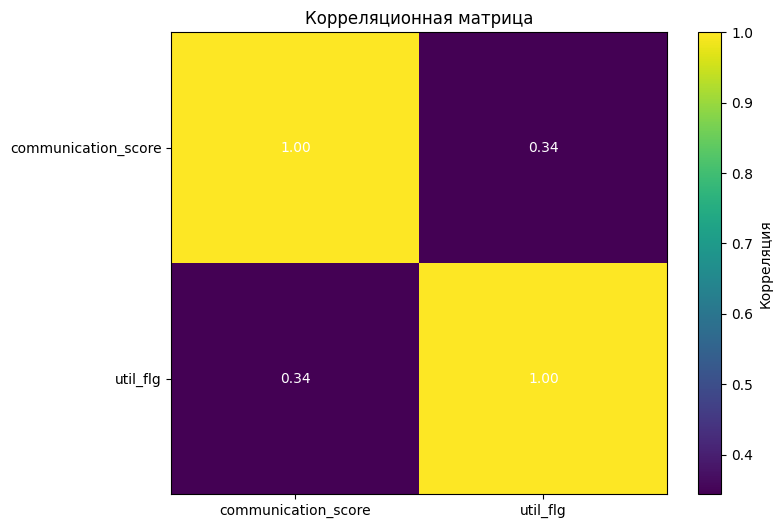

In [12]:
# Считаем корреляцию
correlation_matrix = communications[['communication_score', 'util_flg']].corr()

# Создаем тепловую карту
plt.figure(figsize=(8, 6))
plt.imshow(correlation_matrix.values, cmap='viridis', aspect='auto')

# Добавляем аннотации с значениями
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='white')

# Настройка осей и заголовка
plt.title('Корреляционная матрица')
plt.xticks(range(correlation_matrix.shape[1]), correlation_matrix.columns)
plt.yticks(range(correlation_matrix.shape[0]), correlation_matrix.columns)
plt.xlabel('')
plt.ylabel('')

# Отображение цветовой шкалы
plt.colorbar(label='Корреляция')

# Отображение тепловой карты
plt.show()

Корреляционная матрица показывает следующее:

- Значение `0.34` между `communication_score` и `util_flg` указывает на наличие слабой положительной корреляции. Это означает, что с увеличением оценки коммуникации наблюдается тенденция к увеличению вероятности использования продукта клиентами, но связь не является сильной.
- На основе этой корреляции можно предположить, что хотя качество коммуникации может влиять на решение клиентов о использовании продукта, оно не является единственным фактором, определяющим их выбор.

Произведем временной анализ

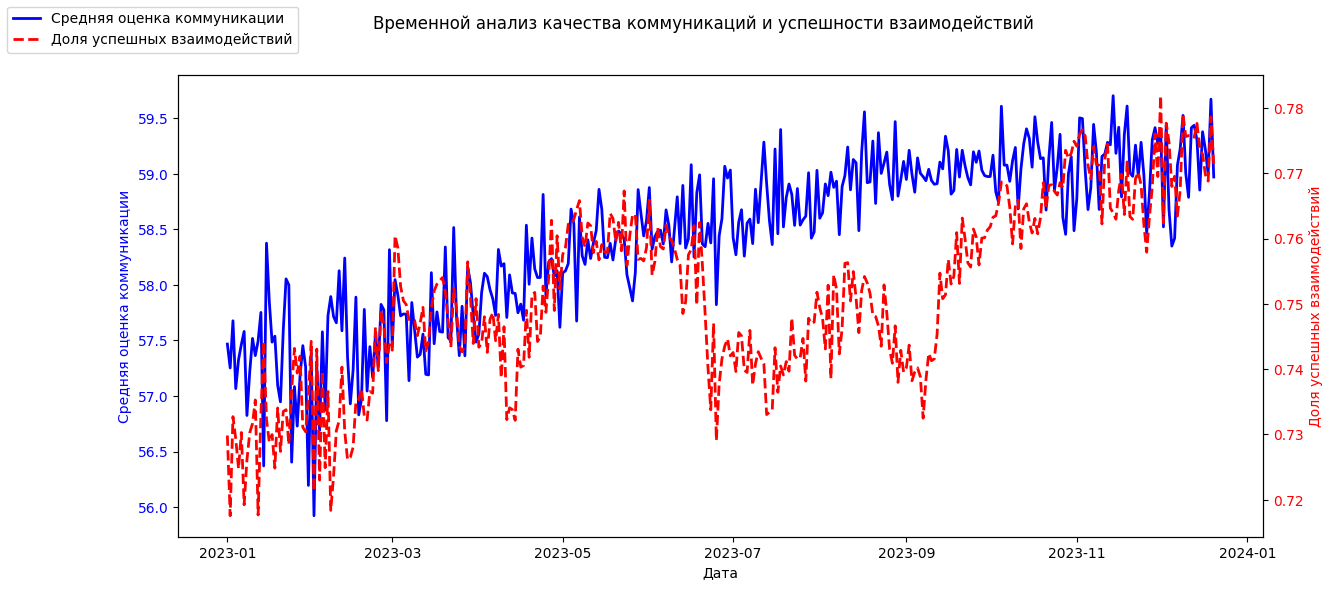

In [13]:
# Преобразование типа данных даты и сортировка
communications['communication_dt'] = pd.to_datetime(communications['communication_dt'])
communications.sort_values('communication_dt', inplace=True)

# Расчет средней оценки коммуникации и доли успешных взаимодействий по датам
daily_avg_score = communications.groupby('communication_dt')['communication_score'].mean()
daily_util_rate = communications.groupby('communication_dt')['util_flg'].mean()

# Создание графика
fig, ax1 = plt.subplots(figsize=(14, 6))

# График средней оценки коммуникации
ax1.plot(daily_avg_score.index, daily_avg_score, color='blue', linewidth=2, label='Средняя оценка коммуникации')
ax1.set_xlabel('Дата')
ax1.set_ylabel('Средняя оценка коммуникации', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Создание второй оси Y для графика доли успешных взаимодействий
ax2 = ax1.twinx()
ax2.plot(daily_util_rate.index, daily_util_rate, color='red', linewidth=2, linestyle='--', label='Доля успешных взаимодействий')
ax2.set_ylabel('Доля успешных взаимодействий', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Настройка заголовка и легенды
fig.suptitle('Временной анализ качества коммуникаций и успешности взаимодействий')
fig.legend(loc='upper left')

# Отображение графика
plt.show()

График представляет временной анализ средней оценки качества коммуникаций и доли успешных взаимодействий.

- **Средняя оценка коммуникации**: Значения колеблются с течением времени, но общий тренд показывает увеличение средней оценки, достигая пика к концу рассматриваемого периода.
- **Доля успешных взаимодействий**: Эта метрика также демонстрирует колебания, однако общее направление тренда указывает на улучшение, с увеличением доли успешных взаимодействий к концу года.

**Общие выводы**:
- Наблюдается положительная тенденция в обеих метриках, что может указывать на улучшение качества коммуникаций и повышение эффективности взаимодействий с течением времени.
- Важно отметить, что моменты сильного увеличения или уменьшения в одной метрике не всегда совпадают с аналогичными изменениями в другой метрике.

Проведем сегментацию сотрудников по успешности коммуникации и взаимодействия

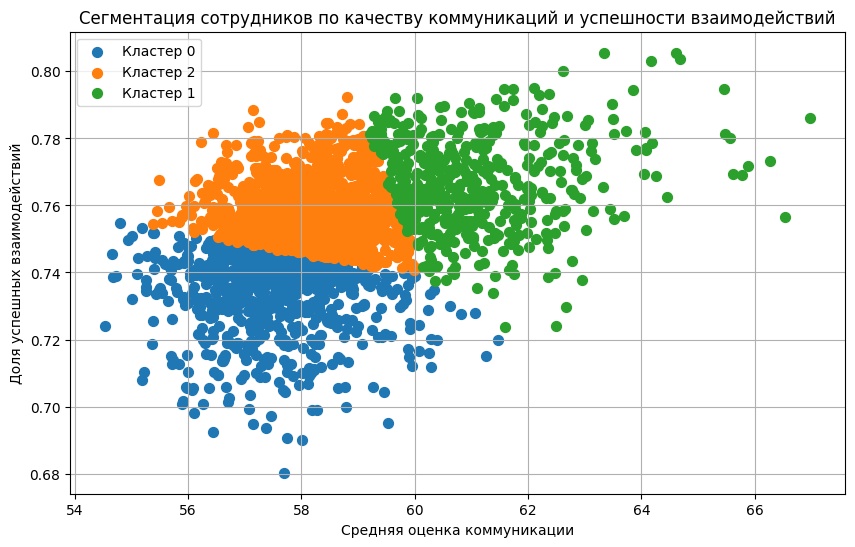

In [14]:
# Рассчитываем среднюю оценку коммуникации и долю успешных взаимодействий для каждого сотрудника
employee_metrics = communications.groupby('employee_id').agg(
    avg_communication_score=('communication_score', 'mean'),
    success_rate=('util_flg', 'mean')
)

# Нормализация данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(employee_metrics)

# Применение K-Means для кластеризации
kmeans = KMeans(n_clusters=3, random_state=12345)
employee_metrics['Cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация результатов кластеризации
plt.figure(figsize=(10, 6))

for cluster in employee_metrics['Cluster'].unique():
    cluster_data = employee_metrics[employee_metrics['Cluster'] == cluster]
    plt.scatter(cluster_data['avg_communication_score'], cluster_data['success_rate'],
                label=f'Кластер {cluster}', s=50)

plt.title('Сегментация сотрудников по качеству коммуникаций и успешности взаимодействий')
plt.xlabel('Средняя оценка коммуникации')
plt.ylabel('Доля успешных взаимодействий')
plt.legend()
plt.grid(True)
plt.show()

График демонстрирует распределение сотрудников по трем кластерам на основе двух переменных: средней оценки коммуникаций и доли успешных взаимодействий.

- **Кластер 0 (синий)**: Сотрудники в этом кластере имеют относительно низкие оценки коммуникации и долю успешных взаимодействий.
- **Кластер 1 (зеленый)**: Этот кластер характеризуется средними значениями по обеим переменным.
- **Кластер 2 (оранжевый)**: Сотрудники, относящиеся к этому кластеру, показывают высокие оценки качества коммуникации и доли успешных взаимодействий.

**Общие выводы**:
- Сотрудники в кластере 2, скорее всего, эффективно коммуницируют и достигают лучших результатов во взаимодействиях с клиентами или коллегами.
- Сотрудники в кластере 0 могут нуждаться в дополнительном обучении или поддержке для улучшения их коммуникационных навыков и увеличения успеха взаимодействий.

## Анализ таблицы Courses_passing

**courses_passing**

Статиситка прохождения обучающих курсов сотрудниками
- course_id – идентификатор курса
- employee_id - идентификатор сотрудника
- pass_frac – доля прохождения курса
- start_dt – дата начала прохождения
- last_activity_dt – последняя активность сотрудника в обучающем курсе
- end_dt – дата окончания обучения. Если обучение пройдено не полностью, то NaN
- educ_duration_days – длительность полного обучения в днях. Если обучение пройдено не полностью, то NaN

In [15]:
# загрузим датасет
courses_passing = pd.read_csv('../data/src/courses_passing.csv', sep=';',  dtype={'employee_id': 'category'})
courses_passing

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,24,53ed35c7-4a2e-c275-b837-374f04396c03,1.00,2023-01-30 00:00:00,2023-02-05 00:00:00,2023-02-05 00:00:00,6.00
1,83,202cb962-ac59-075b-964b-07152d234b70,1.00,2023-08-29 00:00:00,2023-09-10 00:00:00,2023-09-10 00:00:00,12.00
2,4,05f971b5-ec19-6b8c-65b7-5d2ef8267331,1.00,2023-07-29 00:00:00,2023-08-09 00:00:00,2023-08-09 00:00:00,11.00
3,79,f4a331b7-a22d-1b23-7565-d8813a34d8ac,1.00,2023-05-30 00:00:00,2023-06-09 00:00:00,2023-06-09 00:00:00,10.00
4,6,aba3b6fd-5d18-6d28-e06f-f97135cade7f,1.00,2023-07-12 00:00:00,2023-07-22 00:00:00,2023-07-22 00:00:00,10.00
...,...,...,...,...,...,...,...
10945,49,3147da8a-b4a0-437c-15ef-51a5cc7f2dc4,1.00,2023-05-11 00:00:00,2023-05-18 00:00:00,2023-05-18 00:00:00,7.00
10946,16,00e26af6-ac3b-1c1c-49d7-c3d79c60d000,1.00,2023-05-08 00:00:00,2023-05-20 00:00:00,2023-05-20 00:00:00,12.00
10947,40,e5b294b7-0c96-47dc-f804-d7baa1903918,1.00,2023-03-30 00:00:00,2023-04-13 00:00:00,2023-04-13 00:00:00,14.00
10948,24,fb89705a-e6d7-43bf-1e84-8c206e16a1d7,0.05,2023-05-05 00:00:00,2023-05-08 00:00:00,NaN,NaN


In [16]:
# Рассмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   course_id           10950 non-null  int64   
 1   employee_id         10950 non-null  category
 2   pass_frac           10950 non-null  float64 
 3   start_dt            10950 non-null  object  
 4   last_activity_dt    10950 non-null  object  
 5   end_dt              8404 non-null   object  
 6   educ_duration_days  8404 non-null   float64 
dtypes: category(1), float64(2), int64(1), object(3)
memory usage: 613.1+ KB


In [17]:
# Измененим типов данных некоторых столбцов
courses_passing['start_dt'] = pd.to_datetime(courses_passing['start_dt'])
courses_passing['last_activity_dt'] = pd.to_datetime(courses_passing['last_activity_dt'])
courses_passing['end_dt'] = pd.to_datetime(courses_passing['end_dt'])

In [18]:
#Не все сотрудники проходили обучение, а лишь 1758/2381
print('Число человек, прошедших обучение:', courses_passing['employee_id'].nunique())
print('Число уникальных курсов:', courses_passing['course_id'].nunique())

Число человек, прошедших обучение: 1758
Число уникальных курсов: 92


In [19]:
# Доли прохождения обучения
courses_passing['pass_frac'].unique()

array([1.  , 0.1 , 0.55, 0.75, 0.9 , 0.6 , 0.7 , 0.5 , 0.4 , 0.15, 0.45,
       0.95, 0.  , 0.85, 0.35, 0.05, 0.25, 0.65, 0.3 , 0.2 , 0.8 ])

In [20]:
# Рассмотрим информацию по датасету
courses_passing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10950 entries, 0 to 10949
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   course_id           10950 non-null  int64         
 1   employee_id         10950 non-null  category      
 2   pass_frac           10950 non-null  float64       
 3   start_dt            10950 non-null  datetime64[ns]
 4   last_activity_dt    10950 non-null  datetime64[ns]
 5   end_dt              8404 non-null   datetime64[ns]
 6   educ_duration_days  8404 non-null   float64       
dtypes: category(1), datetime64[ns](3), float64(2), int64(1)
memory usage: 613.1 KB


Часть значений отсутствует, если курс не завершен. В таком случае можно ориентироваться на pass_frac

In [21]:
# Рассмотрим пропуски в датасете
courses_passing.isnull().sum()

course_id                0
employee_id              0
pass_frac                0
start_dt                 0
last_activity_dt         0
end_dt                2546
educ_duration_days    2546
dtype: int64

In [22]:
# Расмотрим основные характеристики
courses_passing.describe(include='all')

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
count,10950.00,10950,10950.00,10950,10950,8404,8404.00
unique,NaN,1758,NaN,NaN,NaN,NaN,NaN
top,NaN,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,NaN,NaN,NaN,NaN,NaN
freq,NaN,32,NaN,NaN,NaN,NaN,NaN
mean,44.32,NaN,0.88,2023-05-29 06:49:14.958904064,2023-06-07 04:00:23.671232768,2023-06-08 19:16:35.525939968,10.04
min,0.00,NaN,0.00,2023-01-11 00:00:00,2023-01-13 00:00:00,2023-01-14 00:00:00,1.00
25%,20.00,NaN,1.00,2023-04-11 00:00:00,2023-04-21 00:00:00,2023-04-22 18:00:00,8.00
50%,43.00,NaN,1.00,2023-05-26 00:00:00,2023-06-04 00:00:00,2023-06-06 00:00:00,10.00
75%,67.75,NaN,1.00,2023-07-16 00:00:00,2023-07-25 00:00:00,2023-07-27 00:00:00,12.00
max,91.00,NaN,1.00,2023-11-01 00:00:00,2023-11-16 00:00:00,2023-11-16 00:00:00,23.00


**Обзор данных по обучению сотрудников:**

- **Количество записей**: 10 950 записей, что указывает на активное участие сотрудников в курсах.
- **Уникальные сотрудники**: Данные охватывают 1 758 уникальных сотрудников, многие из которых, возможно, прошли по несколько курсов.
- **Самый активный сотрудник**: Сотрудник с идентификатором `8f1d4362-0bc6-bb58-0df6-e80b0dc05c48` участвовал в наибольшем количестве курсов (32 раза).

**Прохождение курсов (`pass_frac`):**
- **Средний процент успешного завершения курсов**: 0.88, что свидетельствует о высоком уровне "успеваемости" среди сотрудников.
- **Стандартное отклонение**: 0.26, показывая разнообразие в "успеваемости" среди разных сотрудников или курсов.

**Продолжительность обучения (`educ_duration_days`):**
- **Средняя продолжительность обучения**: 10.04 дня, что указывает на относительно короткие курсы.
- **Стандартное отклонение продолжительности обучения**: 3.12 дней, показывая вариативность в длительности различных курсов.
- **Минимальная продолжительность обучения**: 1 день, что может указывать на интенсивные краткосрочные курсы или, к примеруу, оценочные тесты.
- **Максимальная продолжительность обучения**: 23 дня, что может соответствовать более глубоким и подробным курсам.

**Анализ:**
- Данные показывают активное участие сотрудников в обучающих программах, с высоким процентом успешного завершения курсов.
- Вариативность в продолжительности курсов может указывать на широкий спектр предлагаемых обучающих программ, от коротких интенсивных курсов до более длительных и глубоких обучений.

In [23]:
# Рассмотрен произвольный сотрудник и детали о курсах, им пройденных
random_person = courses_passing[(courses_passing['employee_id'] == '8f1d4362-0bc6-bb58-0df6-e80b0dc05c48')]
random_person.head(5)

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
313,15,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,1.00,2023-02-05,2023-02-13,2023-02-13,8.00
515,84,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,1.00,2023-04-03,2023-04-13,2023-04-13,10.00
1513,73,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,1.00,2023-04-26,2023-05-04,2023-05-04,8.00
1521,20,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,1.00,2023-09-04,2023-09-13,2023-09-13,9.00
1693,63,8f1d4362-0bc6-bb58-0df6-e80b0dc05c48,1.00,2023-05-23,2023-06-04,2023-06-04,12.00


In [24]:
random_person.shape

(32, 7)

In [25]:
# Проверка того, что в таблице course_passing для каждого из 1758 сотрудников 
def check_courses_passing():
    """
    Проверка таблицы course_passing для каждого из 1758 сотрудников.

    Args:
    courses_passing (DataFrame): Таблица с данными о прохождении курсов с колонками 'employee_id' и 'course_id'.

    Returns:
    list or str: Список идентификаторов сотрудников, у которых есть более одной отметки за какой-то курс,
                или строка 'Нет сотрудников, у которых о каком-то курсе более 1 отметки'.
    """

    res = []
    employee_ids = courses_passing['employee_id'].unique()

    for employee_id in employee_ids:
        cut = courses_passing[courses_passing['employee_id'] == employee_id]
        all_one = (cut['course_id'].value_counts() == 1).all()

        if not all_one:
            res.append(employee_id)

    return res if len(res) != 0 else 'Нет сотрудников, у которых о каком-то курсе более 1 отметки'


In [26]:
# Запустим функцию
check_courses_passing()

'Нет сотрудников, у которых о каком-то курсе более 1 отметки'

Присутствует только одна запись о прохождении какого-то из курсов

Построим распределение числа курсов, пройденных сотрудниками. 

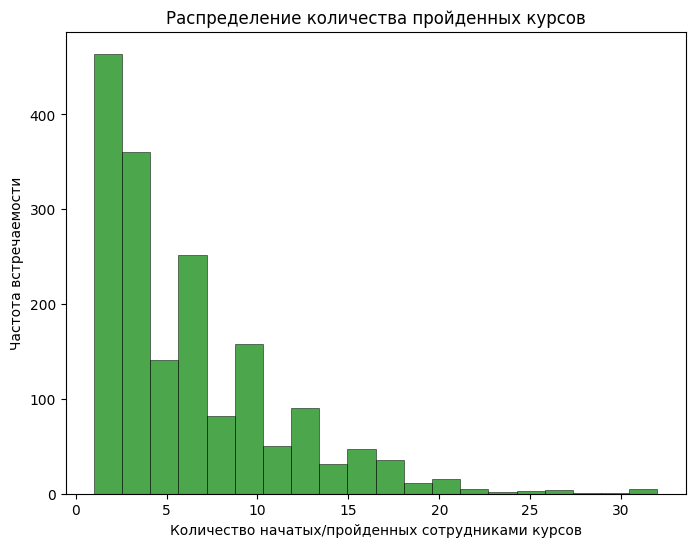

In [27]:
# Подсчет количества курсов, пройденных каждым сотрудником
num_of_courses_passed = courses_passing['employee_id'].value_counts()

# Создание гистограммы распределения количества пройденных курсов
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(num_of_courses_passed, bins=20, color='green', linewidth=0.5, edgecolor="black", alpha=0.7)

# Настройка подписей осей и заголовка
ax.set_xlabel('Количество начатых/пройденных сотрудниками курсов')
ax.set_ylabel('Частота встречаемости')
ax.set_title('Распределение количества пройденных курсов') 

# Отображение гистограммы
plt.show()

График демонстрирует распределение количества курсов, которые начали или прошли сотрудники.

- Большинство сотрудников начали или прошли от 0 до 5 курсов, что является наиболее частым случаем.
- Число сотрудников, проходящих большее количество курсов, снижается по мере увеличения общего числа курсов, что показывает экспоненциальное уменьшение.
- Очень небольшое число сотрудников проходит более 20 курсов, что может указывать на наличие особо мотивированных индивидуумов или на наличие ограничений, не позволяющих большинству сотрудников проходить много курсов.
- Наблюдается резкое уменьшение количества сотрудников с увеличением числа пройденных курсов после 5, что может указывать на высокие требования курсов или на недостаток времени у сотрудников для обучения.

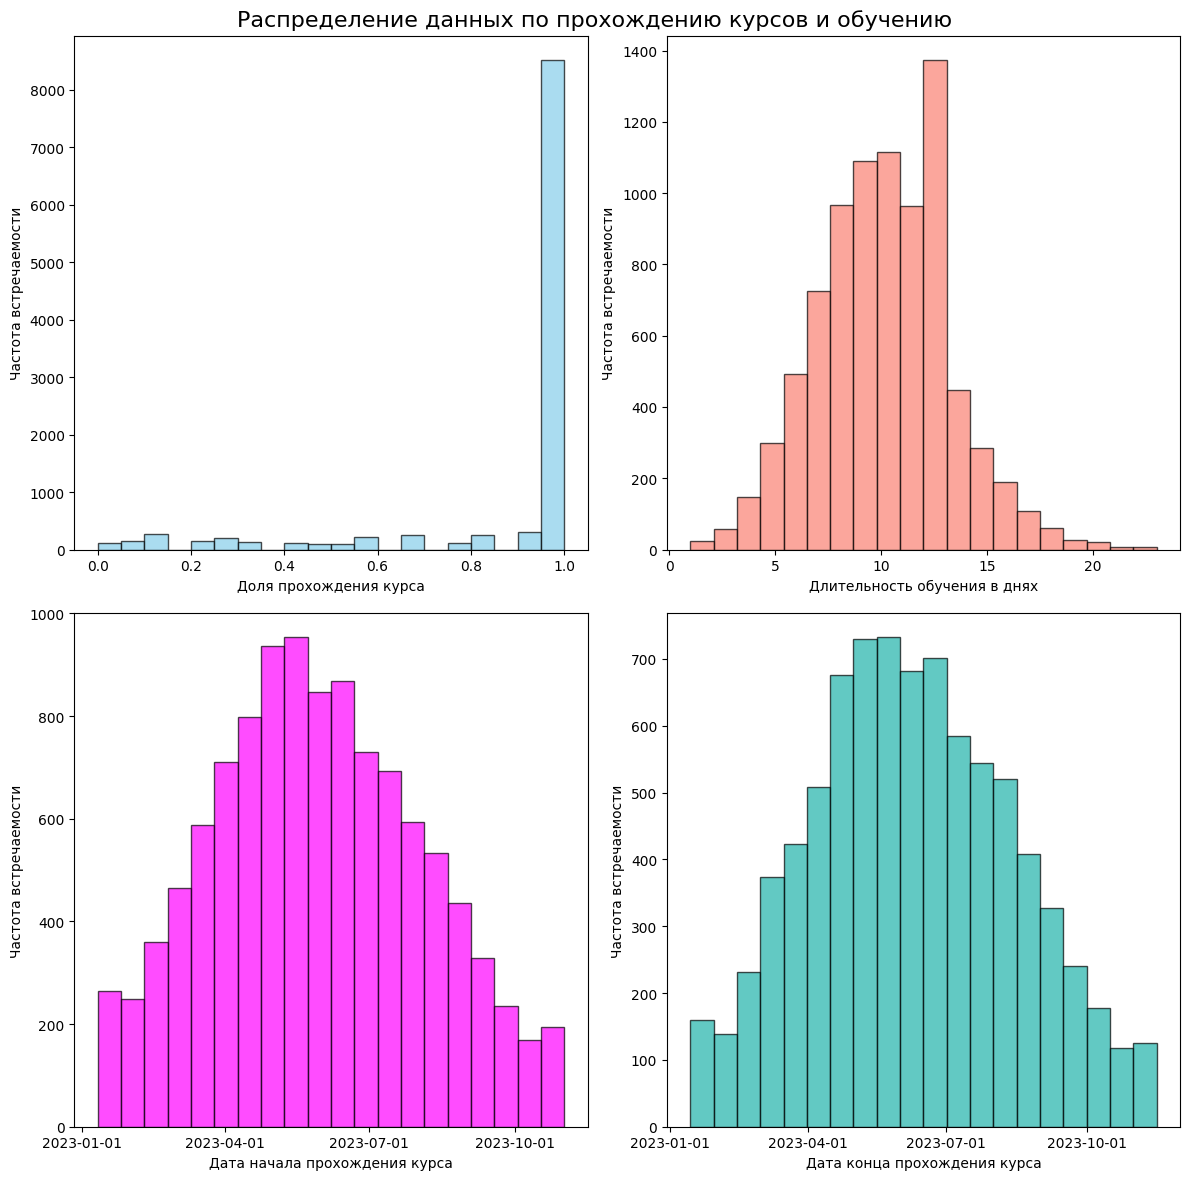

In [28]:
# Построение гистограмм. Оценка распределений, выбросов, шумов
nrows = 2
ncols =2

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
 
# Гистограмма доли прохождения курсов (покрывает тех, кто не завершил обучение)
axes[0][0].hist(courses_passing["pass_frac"], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0][0].set_xlabel('Доля прохождения курса')
axes[0][0].set_ylabel('Частота встречаемости')

# Гистограмма длительности обучения для тех, кто его окончил
axes[0][1].hist(courses_passing["educ_duration_days"], bins=20, color='salmon', edgecolor='black', alpha=0.7)
axes[0][1].set_xlabel('Длительность обучения в днях')
axes[0][1].set_ylabel('Частота встречаемости')

# Гистограмма даты начала прохождения курсов
axes[1][0].hist(courses_passing["start_dt"], bins=20, color='magenta', edgecolor='black', alpha=0.7)
axes[1][0].set_xlabel('Дата начала прохождения курса')
axes[1][0].set_ylabel('Частота встречаемости')
plt.sca(axes[1][0])  
plt.xticks(plt.xticks()[0][::3])

# Гистограмма даты конца прохождения курсов для тех, кто его окончил
axes[1][1].hist(courses_passing["end_dt"], bins=20, color='lightseagreen', edgecolor='black', alpha=0.7)
axes[1][1].set_xlabel('Дата конца прохождения курса')
axes[1][1].set_ylabel('Частота встречаемости')
plt.sca(axes[1][1])  
plt.xticks(plt.xticks()[0][::3]) 

fig.suptitle('Распределение данных по прохождению курсов и обучению', fontsize=16)

plt.tight_layout()
plt.show()

Четыре гистограммы представляют следующие аспекты прохождения курсов:

- **Доля прохождения курса**: Подавляющее большинство сотрудников либо не начинали курс, либо полностью его прошли, что указывает на "всё или ничего" подход в обучении.
- **Длительность обучения в днях**: Наблюдается нормальное распределение с пиком около 10-11 дней, что может указывать на среднюю продолжительность курсов в компании.
- **Дата начала прохождения курса**: Распределение показывает, что есть пики начала курсов, что может соответствовать периодам организации обучения или наличию определенных циклов обучения в компании.
- **Дата окончания прохождения курса**: Похоже на распределение дат начала курсов, с пиками в определенные периоды, что может быть связано с расписанием обучения.

**Выводы**:
- Структура обучения в компании может включать регулярные сессии или периоды, когда обучение становится доступно или рекомендовано.
- Большинство курсов длится около двух недель, что может быть оптимальным временем для завершения образовательных модулей без перегрузки сотрудников.
- Подход "всё или ничего" к прохождению курсов может потребовать более гибкой системы, позволяющей сотрудникам успешно завершать курсы, даже если они не могут полностью посвятить себя обучению.


# Анализ таблицы Employees

**employees**

Информация о сотрудниках колл-центра.
Поля:
- employee_id - идентификатор сотрудника
- sex – пол
- region - идентификатор федерального округа
- age – возраст
- head_employee_id – идентификатор руководителя
- exp_days – опыт в днях
- edu_degree – уровень образования
- department_id – идентификатор департамента, в котором работает сотрудник
- work_online_flg – флаг работы на удалённом режиме

In [29]:
# Загрузим датасет с определением типа данных по столбцам
employees = pd.read_csv('../data/src/employees.csv', sep=';', dtype={'employee_id': 'category', 'head_employee_id': 'category', 'sex': 'category'})
employees.head(5)

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
0,0f840be9-b8db-4d3f-bd5b-a2ce59211f55,M,4,36,c81e728d-9d4c-2f63-6f06-7f89cc14862c,734,0,2,1
1,ac1dd209-cbcc-5e5d-1c6e-28598e8cbbe8,M,4,32,93db85ed-909c-1383-8ff9-5ccfa94cebd9,654,0,2,1
2,a8c88a00-55f6-36e4-a163-a5e3d16adab7,F,5,34,9a115815-4dfa-42ca-ddbd-0694a4e9bdc8,276,1,2,1
3,c91591a8-d461-c286-9b9f-535ded3e213e,F,4,33,9f61408e-3afb-633e-50cd-f1b20de6f466,50,2,0,1
4,bc731692-9fe1-545b-f0b9-8d114ee3ecb8,M,0,33,a97da629-b098-b75c-294d-ffdc3e463904,274,1,2,1


In [30]:
# рассмотрим информацию о датасете
employees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2381 entries, 0 to 2380
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   employee_id       2381 non-null   category
 1   sex               2381 non-null   category
 2   region            2381 non-null   int64   
 3   age               2381 non-null   int64   
 4   head_employee_id  2381 non-null   category
 5   exp_days          2381 non-null   int64   
 6   edu_degree        2381 non-null   int64   
 7   department_id     2381 non-null   int64   
 8   work_online_flg   2381 non-null   int64   
dtypes: category(3), int64(6)
memory usage: 211.7 KB


In [31]:
# Выведем информацию о числе сотрудников
print('Число уникальных начальников', employees['head_employee_id'].nunique())

Число уникальных начальников 132


In [32]:
# Расмотрим основные характеристики
employees.describe(include='all')

,employee_id,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
count,2381,2381,2381.00,2381.00,2381,2381.00,2381.00,2381.00,2381.00
unique,2381,2,NaN,NaN,132,NaN,NaN,NaN,NaN
top,0004d0b5-9e19-461f-f126-e3a08a814c33,M,NaN,NaN,3c59dc04-8e88-5024-3be8-079a5c74d079,NaN,NaN,NaN,NaN
freq,1,1252,NaN,NaN,28,NaN,NaN,NaN,NaN
mean,NaN,NaN,2.77,32.65,NaN,461.73,1.55,1.43,0.57
std,NaN,NaN,2.29,6.75,NaN,374.56,0.60,0.70,0.50
min,NaN,NaN,0.00,19.00,NaN,0.00,0.00,0.00,0.00
25%,NaN,NaN,0.00,28.00,NaN,180.00,1.00,1.00,0.00
50%,NaN,NaN,3.00,32.00,NaN,362.00,2.00,2.00,1.00
75%,NaN,NaN,4.00,37.00,NaN,638.00,2.00,2.00,1.00


**Профили сотрудников:**

- **Количество записей**: Данные охватывают 2 381 сотрудника, из  которых 132 начальника

**Демографические и профессиональные характеристики:**

- **Пол**: Среди сотрудников 1 252 мужчин и остальные женщины, что делает распределение полов относительно сбалансированным.
- **Регион**: Сотрудники распределены по 8 регионам (от 0 до 7).
- **Возраст**: Средний возраст сотрудников составляет 32.65 лет со стандартным отклонением 6.75 лет, диапазон возрастов - от 19 до 60 лет, что свидетельствует о широком возрастном разнообразии в коллективе.
- **Опыт работы (в днях)**: Средний стаж работы сотрудников составляет 461.73 дня, с максимальным стажем в 2424 дня, что указывает на наличие как новичков, так и опытных сотрудников.
- **Уровень образования**: Значения `edu_degree` варьируются от 0 до 2, что может указывать на различные уровни образовательной подготовки сотрудников.
- **Работа онлайн**: Приблизительно 57% сотрудников имеют возможность работать онлайн (`work_online_flg` = 1), что подчеркивает гибкость рабочих условий.

**Анализ:**

- **Разнообразие в коллективе**: Данные подчеркивают разнообразие сотрудников по полу, возрасту, региону проживания и образовательному уровню, что может способствовать широкому спектру идей и подходов в рабочем процессе.
- **Гибкость в работе**: Наличие возможности работать онлайн у значительной части сотрудников говорит о гибкости в организации рабочего процесса, что может быть особенно актуально в современных условиях.
- **Опыт работы**: Распределение по стажу работы показывает, что в коллективе присутствуют как новые, так и опытные кадры, что может способствовать обмену знаниями и опытом внутри организации.
- Возможно, на то, что у сотрудника какого-то будут покупать продукт, будет влиять не прохождение курсов, а уровень образования, опыт, формат работы (онлайн/оффлайн), даже если этот сотрудник проходил популярный курс. Это про causal inference. Не подтвердилось пока.
- Итак, когда по некоторым параметрам будет определен популярный курс, нужно будет отследить, точно ли успех в работе связан с курсом, а не с другими факторами (конфаундер, т.е. мешающий фактор)

In [33]:
#Корреляционная матрица. 
corr_matrix = employees.corr(numeric_only=True)
corr_matrix.style.background_gradient(cmap='coolwarm').format(precision = 2)

,region,age,exp_days,edu_degree,department_id,work_online_flg
region,1.00,-0.02,0.03,0.01,-0.00,-0.01
age,-0.02,1.00,0.02,-0.02,0.00,0.01
exp_days,0.03,0.02,1.00,0.01,0.00,-0.01
edu_degree,0.01,-0.02,0.01,1.00,-0.02,0.05
department_id,-0.00,0.00,0.00,-0.02,1.00,0.01
work_online_flg,-0.01,0.01,-0.01,0.05,0.01,1.00


В таблице employees корреляции между числовыми параметрами отсутствуют 

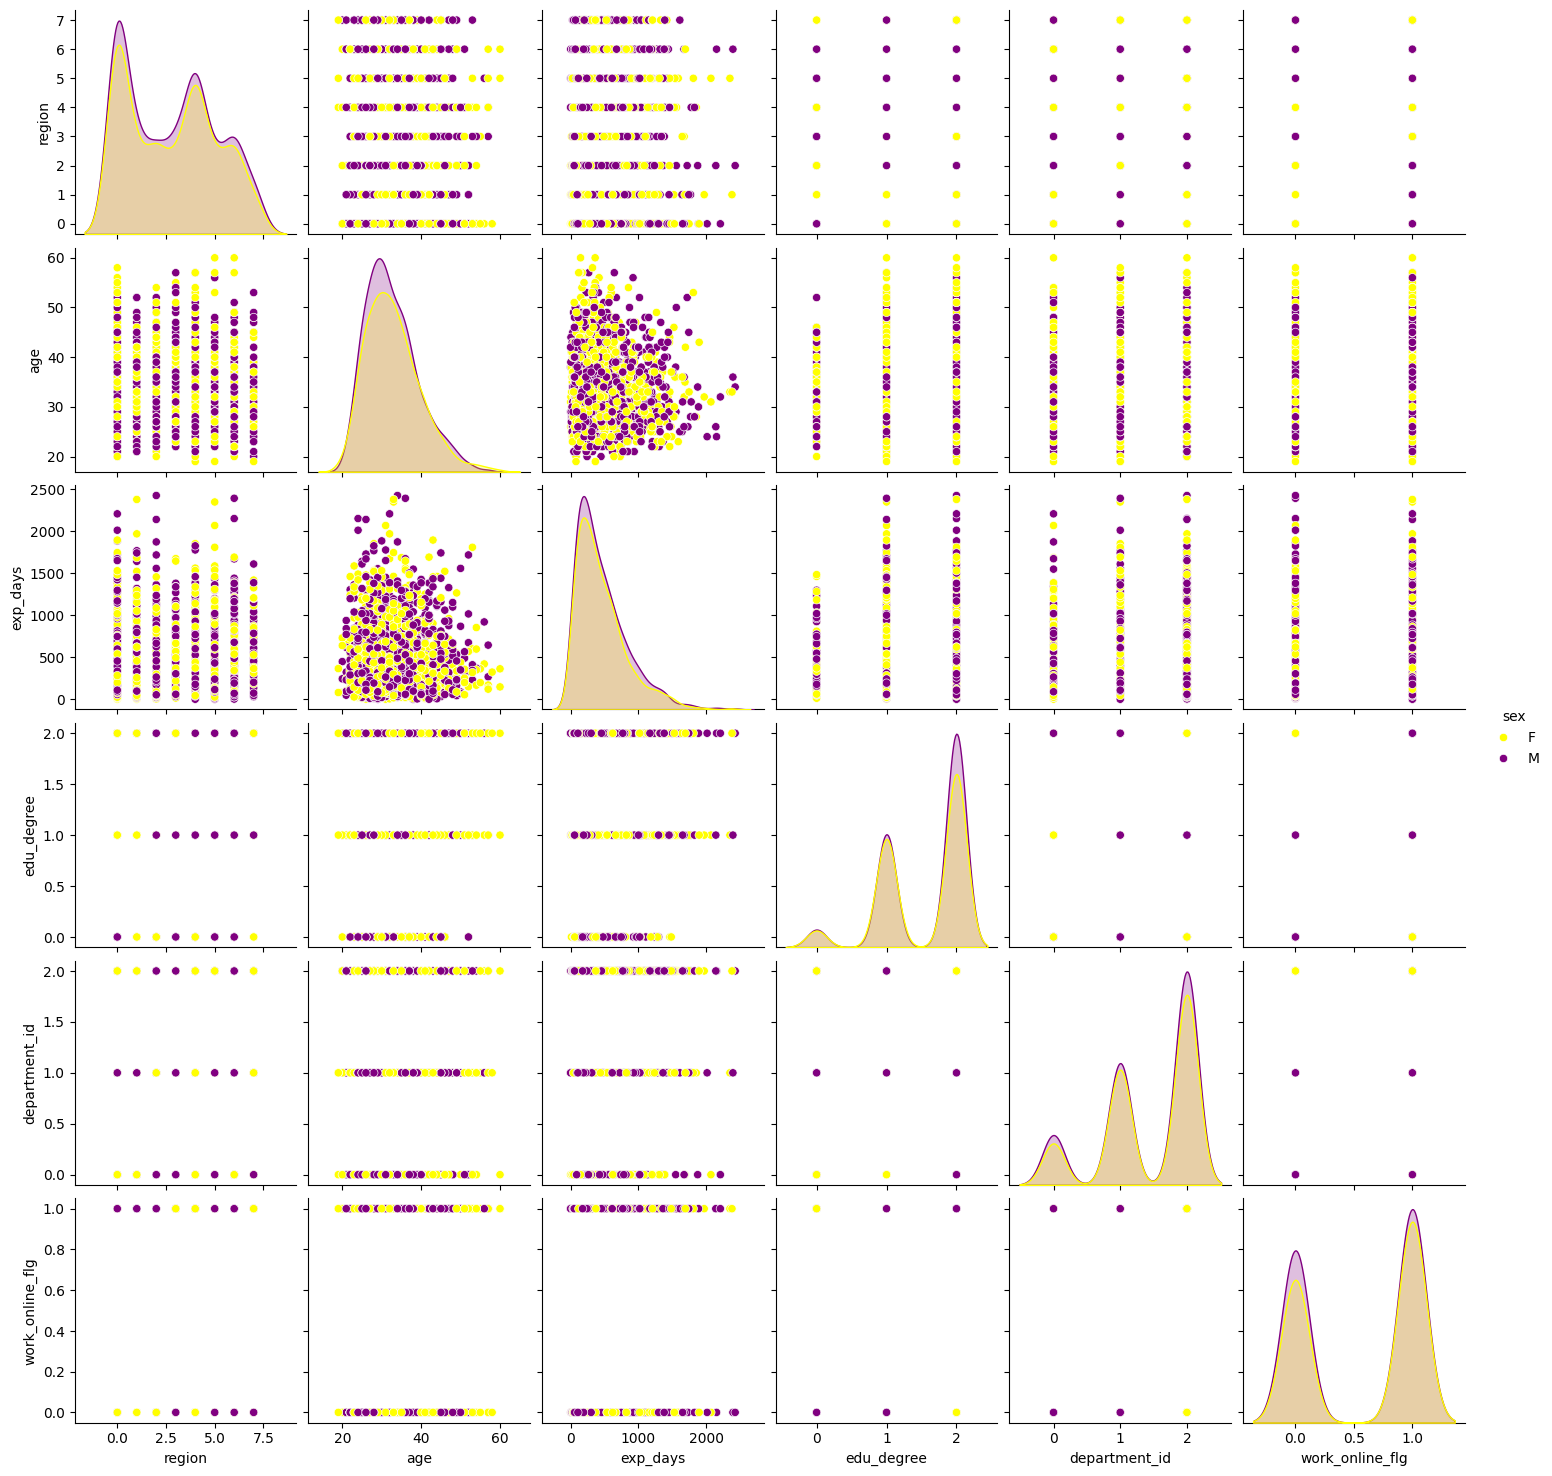

In [34]:
# Построим pairplot
sns.pairplot(employees, hue='sex', palette=('#FFFF00', '#800080'))

График включает следующие переменные: регион (`region`), возраст (`age`), опыт в днях (`exp_days`), образование (`edu_degree`), идентификатор департамента (`department_id`), работа в режиме онлайн (`work_online_flg`), а также пол (`sex`).

- Цвет точек и диаграмм отображает пол (`sex`)
- Полосы на диаграммах рассеяния для категориальных переменных указывают на отдельные категории или группы в данных.

**Выводы**:
- В данных присутствует разнообразие с точки зрения демографических и профессиональных характеристик сотрудников.
- Отдельные категории, такие как `edu_degree` и `department_id`, имеют несколько ярко выраженных групп, что может отражать различные уровни образования и структуру организации.
- Разделение по полу (`sex`) в некоторых диаграммах рассеяния может указывать на различия в распределении других переменных между мужчинами и женщинами.
- Сотрудников, которые доходят курсы до конца или имеют высокий процент прохождения (pass_frac > 0.85) объединяет:
    - возраст - сотрудники, возраст которых приближается к 60, склонны проходить курсы на 100% сильнее других возрастных групп
    - опыт работы в днях - сотрудники с опытом работы (exp_days) более 1700-1800 дней также более склонны проходить курсы на 100%**

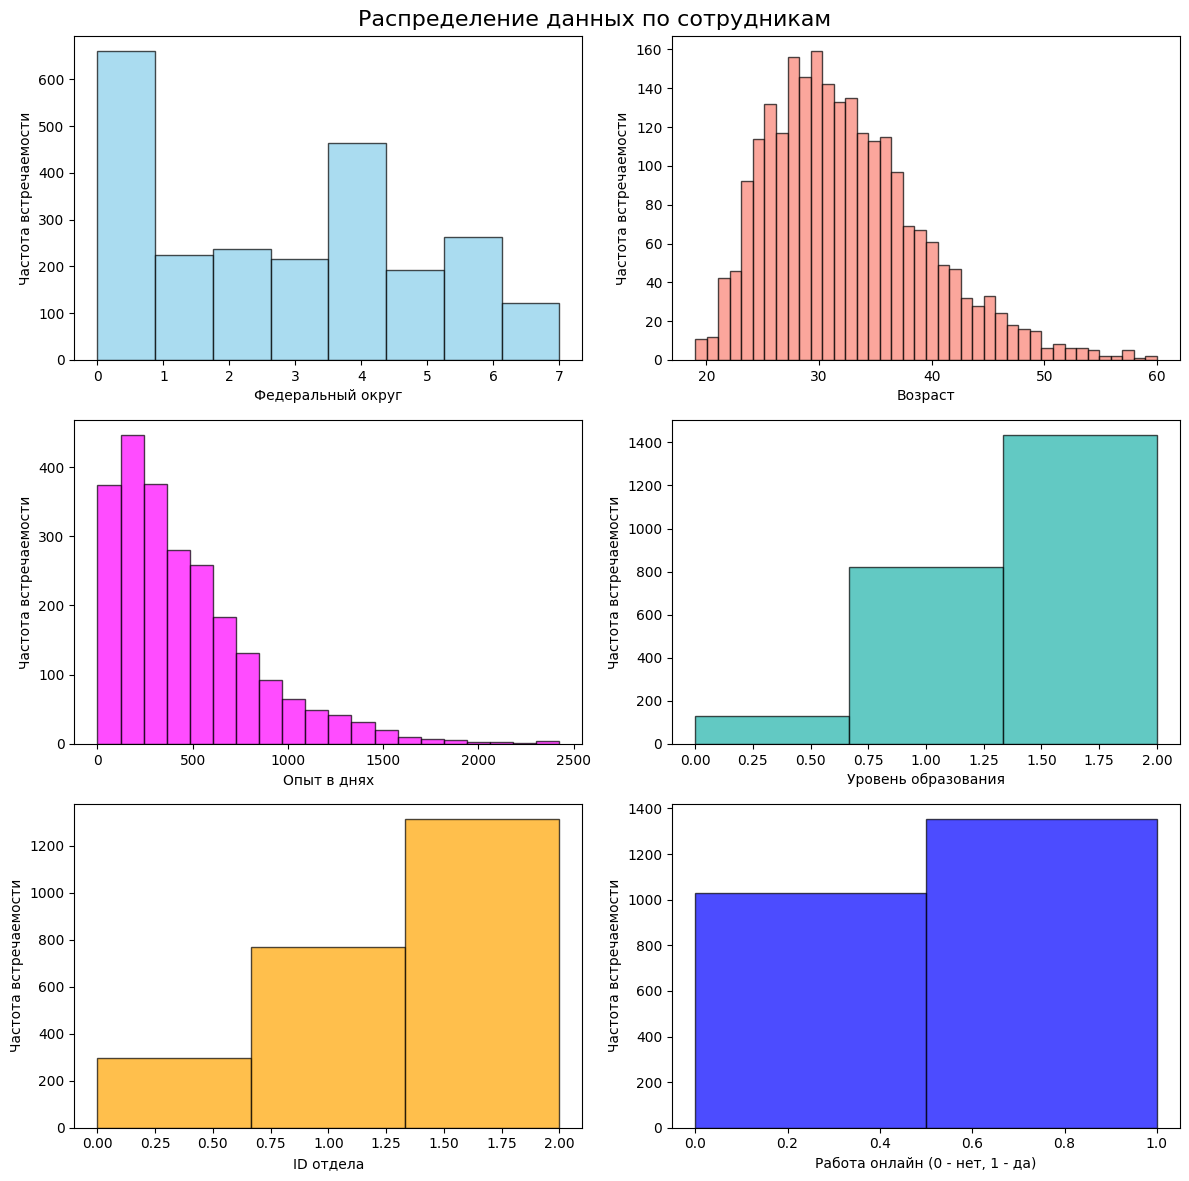

In [35]:
# Построение гистограммы
nrows = 3  # количество строк в сетке графиков
ncols = 2  # количество столбцов в сетке графиков

# Создание фигуры и массива осей для графиков
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 12))
        
# Гистограмма регионов
axes[0][0].hist(employees["region"], bins=8, color='skyblue', edgecolor='black', alpha=0.7)
axes[0][0].set_xlabel('Федеральный округ')
axes[0][0].set_ylabel('Частота встречаемости')

# Гистограмма возраста
axes[0][1].hist(employees["age"], bins=40, color='salmon', edgecolor='black', alpha=0.7)
axes[0][1].set_xlabel('Возраст')
axes[0][1].set_ylabel('Частота встречаемости')

# Гистограмма опыта работы в днях
axes[1][0].hist(employees["exp_days"], bins=20, color='magenta', edgecolor='black', alpha=0.7)
axes[1][0].set_xlabel('Опыт в днях')
axes[1][0].set_ylabel('Частота встречаемости')

# Гистограмма уровня образования
axes[1][1].hist(employees["edu_degree"], bins=3, color='lightseagreen', edgecolor='black', alpha=0.7)
axes[1][1].set_xlabel('Уровень образования')
axes[1][1].set_ylabel('Частота встречаемости')

# Гистограмма ID отделов
axes[2][0].hist(employees["department_id"], bins=3, color='orange', edgecolor='black', alpha=0.7)
axes[2][0].set_xlabel('ID отдела')
axes[2][0].set_ylabel('Частота встречаемости')

# Гистограмма флага работы онлайн
axes[2][1].hist(employees['work_online_flg'], bins=2, color='blue', edgecolor='black', alpha=0.7)
axes[2][1].set_xlabel('Работа онлайн (0 - нет, 1 - да)')
axes[2][1].set_ylabel('Частота встречаемости')

# Добавление заголовка
fig.suptitle('Распределение данных по сотрудникам', fontsize=16)

# Выравнивание графиков и отображение
plt.tight_layout()
plt.show()

На шести гистограммах изображено распределение сотрудников по следующим параметрам:

- **Федеральный округ**: Большинство сотрудников находится в первом и четвертом федеральных округах, с меньшим числом в остальных.
- **Возраст**: Распределение возраста сотрудников имеет пик в районе 28-33 года и уменьшается по мере приближения к 60 годам.
- **Опыт работы в днях**: Большая часть сотрудников имеет опыт работы от 0 до 500 дней, что указывает на относительно молодой коллектив с точки зрения стажа работы.
- **Уровень образования**: Подавляющее большинство сотрудников имеет высшее образование.
- **ID отдела**: Сотрудники в основном сосредоточены во 2-м отделе, что может указывать на большое число сотрудников в этом департаменте.
- **Работа онлайн**: Большинство сотрудников работают не онлайн, с меньшей долей тех, кто работает онлайн.

**Выводы**:
- Распределение по федеральным округам и ID отдела может отражать структуру компании и её географическое положение.
- Возрастной состав сотрудников и их опыт работы указывают на молодую рабочую силу.
- Высокий уровень образования среди сотрудников может говорить о квалификации и потенциале для развития.
- Низкая доля удаленной работы может быть связана с спецификой работы или корпоративной культурой.

# Анализ таблицы Course_employee_sms

**course_employee_sms**

Сводная таблица с нотификациями сотрудникам с предложением пройти обучение. Нотификации рассылались случайным образом
Поля:
- employee_id - идентификатор сотрудника
- course_i – флаг наличия нотификации

In [36]:
# Загрузим данные
course_employee_sms = pd.read_csv('../data/src/course_employee_sms.csv', sep=';')

In [37]:
# Рассмотрим первые строки таблицы
course_employee_sms.head()

,employee_id,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,...,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91
0,2a38a4a9-316c-49e5-a833-517c45d31070,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,4e0928de-0755-38c5-93fb-dabb0c5ef2c3,0,0,0,1,0,0,0,0,1,...,1,1,1,1,0,0,0,0,1,0
2,1ff1de77-4005-f8da-13f4-2943881c655f,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
3,cd3afef9-b8b8-9558-cd56-638c3631868a,0,0,1,1,1,0,0,0,1,...,1,0,1,1,1,0,1,1,1,0
4,dc513ea4-fbda-a7a1-4786-ffdebc4ef64e,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


Здесь могут быть и те курсы, от прохождения которых человек отказался

In [38]:
# Расмотрим основные характеристики
course_employee_sms.describe(include='all')

,employee_id,course_0,course_1,course_2,course_3,course_4,course_5,course_6,course_7,course_8,...,course_82,course_83,course_84,course_85,course_86,course_87,course_88,course_89,course_90,course_91
count,2381,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,...,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00,2381.00
unique,2381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,2a38a4a9-316c-49e5-a833-517c45d31070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.30,0.30,0.31,0.30,0.31,0.31,0.30,0.31,0.30,...,0.29,0.28,0.30,0.30,0.28,0.30,0.32,0.30,0.30,0.32
std,NaN,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,0.46,...,0.45,0.45,0.46,0.46,0.45,0.46,0.47,0.46,0.46,0.47
min,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,NaN,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


**Обзор данных по курсам и участию сотрудников:**

- **Количество записей**: Данные включают информацию о 2 381 сотрудниках.

**Участие в курсах:**

- Каждый сотрудник имеет данные об участии в 92 различных курсах (`course_0` до `course_91`).
- **Среднее участие**: Для большинства курсов среднее участие (прохождение курса) колеблется около 0.30, что указывает на то, что в среднем около 30% сотрудников прошли каждый курс.
- **Стандартное отклонение**: Стандартное отклонение участия в курсах варьируется около 0.46, что говорит о значительном разбросе в данных: многие сотрудники не прошли курс (0), в то время как другие успешно его завершили (1).

**Анализ:**

- **Активность сотрудников**: Данные показывают, что сотрудники вовлечены в различные образовательные программы, однако степень участия сильно различается между отдельными курсами и сотрудниками.

# Анализ таблицы Courses_info

In [39]:
# Загрузим данные
courses_info = pd.read_csv('../data/src/courses_info.csv', sep=';')
courses_info

,course_id,course_nm
0,3,Улучшение качества обслуживания клиентов: Осно...
1,76,Как эффективно использовать психологию в обслу...
2,22,Эффективное обучение клиентов в использовании ...
3,53,Как эффективно реагировать на изменения потреб...
4,7,Построение долгосрочных отношений с клиентами:...
...,...,...
87,0,Основы клиентского сервиса: Практический подход
88,14,Повышение лояльности клиентов через качественн...
89,5,Проактивное обслуживание клиентов: Ключевые ст...
90,26,Использование аналитики данных для оптимизации...


In [40]:
# Рассмотрим список курсов
courses_info['course_nm'].unique()

array(['Улучшение качества обслуживания клиентов: Основные принципы',
       'Как эффективно использовать психологию в обслуживании клиентов',
       'Эффективное обучение клиентов в использовании продукта или услуги',
       'Как эффективно реагировать на изменения потребностей клиентов',
       'Построение долгосрочных отношений с клиентами: Техники и методы',
       'Эффективное проведение клиентских опросов и исследований',
       'Развитие навыков активного прослушивания в клиентском сервисе',
       'Продвинутые методы анализа и интерпретации клиентских данных',
       'Эффективное планирование и организация работы в клиентском сервисе',
       'Использование техник активного слушания в общении с клиентами',
       'Использование мультимедийных инструментов в клиентском сервисе',
       'Как строить доверительные отношения с клиентами',
       'Управление нестандартными ситуациями в клиентском обслуживании',
       'Методы оценки и улучшения качества обслуживания клиентов',
     

In [41]:
# Рассмотрим количество курсов
print(courses_info['course_id'].nunique())
print(courses_info['course_nm'].nunique())

92
92


In [42]:
# Рассмотрим информацию по датасету
courses_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   course_id  92 non-null     int64 
 1   course_nm  92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


# Объединение таблиц и разведовательный анализ

In [43]:
# Объединяем таблицы communications и employees, внутреннее соединение, т.к. в обеих
# таблицах присутствуют все сотрудники employee_id
merged = pd.merge(communications, employees, on='employee_id', how='inner')
print(merged.shape)
merged.head(5)

(5345246, 13)


,communication_id,communication_dt,employee_id,communication_score,util_flg,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg
0,265773861079506507,2023-01-01,cf2226dd-d41b-1a2d-0ae5-1dab54d32c36,0,0,F,1,30,43ec517d-68b6-edd3-015b-3edc9a11367b,197,2,2,1
1,278568857626326381,2023-01-01,7f5d04d1-89df-b634-e6a8-5bb9d9adf21e,68,1,M,1,33,43ec517d-68b6-edd3-015b-3edc9a11367b,90,1,2,0
2,466811215985540640,2023-01-01,04ecb1fa-2850-6ccb-6f72-b12c0245ddbc,0,0,F,2,37,e4da3b7f-bbce-2345-d777-2b0674a318d5,72,2,1,0
3,187483347234781892,2023-01-01,af3303f8-52ab-eccd-7930-68486a391626,100,0,M,0,36,2723d092-b638-85e0-d7c2-60cc007e8b9d,651,1,0,1
4,47065300189886434,2023-01-01,16026d60-ff9b-5441-0b34-35b403afd226,0,1,F,0,36,ec895663-7a99-787b-d197-eacd77acce5e,73,2,1,1


In [44]:
# Рассмотрим информацию о датасете
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345246 entries, 0 to 5345245
Data columns (total 13 columns):
 #   Column               Dtype         
---  ------               -----         
 0   communication_id     int64         
 1   communication_dt     datetime64[ns]
 2   employee_id          category      
 3   communication_score  int64         
 4   util_flg             int64         
 5   sex                  category      
 6   region               int64         
 7   age                  int64         
 8   head_employee_id     category      
 9   exp_days             int64         
 10  edu_degree           int64         
 11  department_id        int64         
 12  work_online_flg      int64         
dtypes: category(3), datetime64[ns](1), int64(9)
memory usage: 433.4 MB


In [81]:
# Рассмотрим значения по опыту и возрасту
print('Уникальных значений опыта, дней', merged['exp_days'].nunique()) #надо создать интервалы длительности опыта
print('Уникальных значений возраста, лет', merged['age'].nunique()) #аналогично надо сгруппировать

Уникальных значений опыта, дней 1005
Уникальных значений возраста, лет 41


Сгенерируем дополнительные признаки по возрасту и опыту работы

In [82]:
#Генерация дополнительного признака - группы по возрасту 
# 1 = 'age 19-29', 2=  'age 30-39', 3 ='age 40-49', 4 ='age 50-60'
merged['age_group'] = pd.cut(merged['age'], bins=4, labels=['1', '2', '3', '4'])

#Генерация дополнительного признака - группы по опыту работы 
# 1 = '0-606 дней', 2=  '607-1212 дней', 3 ='1213-1818 дней', 4 ='1819-2424 дней'
merged['exp_days_group'] = pd.cut(merged['exp_days'], bins=4, labels=['1', '2', '3', '4'])

In [83]:
# Посмотрим результат
merged.head(5)

,communication_id,communication_dt,employee_id,communication_score,util_flg,sex,region,age,head_employee_id,exp_days,edu_degree,department_id,work_online_flg,age_group,exp_days_group
0,265773861079506507,2023-01-01,cf2226dd-d41b-1a2d-0ae5-1dab54d32c36,0,0,F,1,30,43ec517d-68b6-edd3-015b-3edc9a11367b,197,2,2,1,2,1
1,278568857626326381,2023-01-01,7f5d04d1-89df-b634-e6a8-5bb9d9adf21e,68,1,M,1,33,43ec517d-68b6-edd3-015b-3edc9a11367b,90,1,2,0,2,1
2,466811215985540640,2023-01-01,04ecb1fa-2850-6ccb-6f72-b12c0245ddbc,0,0,F,2,37,e4da3b7f-bbce-2345-d777-2b0674a318d5,72,2,1,0,2,1
3,187483347234781892,2023-01-01,af3303f8-52ab-eccd-7930-68486a391626,100,0,M,0,36,2723d092-b638-85e0-d7c2-60cc007e8b9d,651,1,0,1,2,2
4,47065300189886434,2023-01-01,16026d60-ff9b-5441-0b34-35b403afd226,0,1,F,0,36,ec895663-7a99-787b-d197-eacd77acce5e,73,2,1,1,2,1


Выяснение того, какие курсы проходили сотрудники, показавшие лучшие результаты

In [84]:
# Сотрудники, показывающие лучшие результаты по убыванию
empl_res = merged.groupby('employee_id', as_index=False)['util_flg'].sum().sort_values(by ='util_flg', ascending=False)
empl_res

,employee_id,util_flg
2243,f337d999-d9ad-116a-7b4f-3d409fcc6480,2438
2008,d96409bf-8942-1768-6ba1-24d7356686c9,2432
1051,7137debd-45ae-4d0a-b9aa-953017286b20,2415
1487,a07c2f3b-3b90-7aaf-8436-a26c6d77f0a2,2373
572,3988c7f8-8ebc-b58c-6ce9-32b957b6f332,2350
...,...,...
1433,9a440050-1feb-b2a9-5e79-248486a5f6d3,1081
44,03e7d2eb-ec1e-820a-c34d-054df7e68f48,1077
1345,912d2b1c-7b28-26ca-f996-87388d2e8f7c,1065
1988,d7a728a6-7d90-9e71-4c07-74e22cb806f2,1062


In [85]:
# Посмотрим основные характеристики
empl_res.describe()

,util_flg
count,2381.00
mean,1689.27
std,220.88
min,1058.00
25%,1545.00
50%,1686.00
75%,1842.00
max,2438.00


Результаты `empl_res` показывают распределение суммарного использования продукта или услуги (представленного `util_flg`) среди сотрудников:

- Среднее количество успешных взаимодействий по `util_flg` на сотрудника составляет 1689.27.
- Стандартное отклонение равно 220.88, что свидетельствует о вариативности в показателе успешности коммуникаций среди сотрудников.
- Минимальное значение в столбце `util_flg` равно 1058, в то время как максимальное — 2438, что показывает широкий диапазон в количестве успешных коммуникаций.
- 25% сотрудников имеют показатель успешных коммуникаций продукта ниже 1545, а 75% — ниже 1842, что говорит о том, что большая часть сотрудников по этому показателю находится между этими значениями.

Верхние строки таблицы с данными выделяют сотрудников с наибольшим количеством успешных коммуникаций, где первые пять сотрудников показывают особенно высокую активность. Это может свидетельствовать о высоком уровне вовлеченности.

**Выводы**:
- Существует значительный разброс в количестве успешных коммуникация за период среди сотрудников.
- Некоторые сотрудники показывают исключительно высокие результаты, что может требовать дополнительного изучения для понимания причин такой активности.
- Учитывая стандартное отклонение и разницу между квартилями, можно сделать вывод о неравномерности вовлеченности сотрудников в обеспечении успешных коммуникаций.

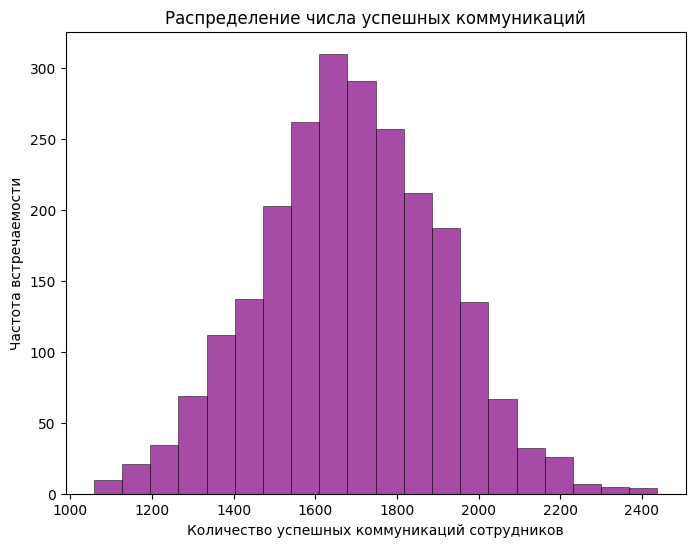

In [86]:
# Распределение числа успешных коммуникаций сотрудников, в среднем 1690 за историю наблюдений
fig, ax = plt.subplots(figsize=(8, 6))
ax.hist(empl_res['util_flg'], bins=20, color='purple', linewidth=0.5, edgecolor="black", alpha=0.7)
ax.set_xlabel('Количество успешных коммуникаций сотрудников')
ax.set_ylabel('Частота встречаемости')
ax.set_title('Распределение числа успешных коммуникаций')
plt.show()

График показывает распределение количества успешных коммуникаций сотрудников:

- Большинство сотрудников имеет от 1400 до 2000 успешных коммуникаций.
- Распределение близко к нормальному, с центром примерно в районе 1700 успешных коммуникаций.
- Наличие сотрудников с очень высоким и очень низким числом успешных коммуникаций является относительно небольшим.

**Выводы**:
- Данные показывают, что большинство сотрудников имеют схожий уровень успеха в коммуникациях.
- Отсутствие значительного числа сотрудников с очень низким количеством успешных коммуникаций может свидетельствовать о хорошем уровне подготовки персонала и эффективности коммуникационных стратегий в компании.
- Сотрудники с высоким количеством успешных коммуникаций могут быть идентифицированы как высокопроизводительные и использованы в качестве примеров для обучения или наставничества.

Эти данные могут служить основой для развития персонала и дальнейшего анализа коммуникационных стратегий в компании.

In [87]:
# Отбираем статистически лучших сотрудников
empl_res[((empl_res['util_flg'] >= 1842) & (empl_res['util_flg'] <= 2438))]

,employee_id,util_flg
2243,f337d999-d9ad-116a-7b4f-3d409fcc6480,2438
2008,d96409bf-8942-1768-6ba1-24d7356686c9,2432
1051,7137debd-45ae-4d0a-b9aa-953017286b20,2415
1487,a07c2f3b-3b90-7aaf-8436-a26c6d77f0a2,2373
572,3988c7f8-8ebc-b58c-6ce9-32b957b6f332,2350
...,...,...
2018,dabd8d2c-e74e-782c-65a9-73ef76fd540b,1842
139,0cb929ea-e7a4-99e5-0248-a3a78f7acfc7,1842
728,4c144c47-ecba-6f83-1812-8703ca9e2601,1842
2067,df9028fc-b6b0-65e0-00ff-e8a4f03eeb38,1842


In [88]:
# Таблица, в которой отражены сотрудники с самыми высокими результатами и пройденные ими курсы
best_results = np.empty((0, courses_passing.shape[1]))

for elem in empl_res['employee_id']:
    res = courses_passing[(courses_passing['employee_id'] == elem)].values
    best_results = np.vstack((best_results, res))

    best_results_df = pd.DataFrame(best_results, columns = courses_passing.columns)
best_results_df

,course_id,employee_id,pass_frac,start_dt,last_activity_dt,end_dt,educ_duration_days
0,35,f337d999-d9ad-116a-7b4f-3d409fcc6480,0.65,2023-08-14,2023-08-22,NaT,NaN
1,45,f337d999-d9ad-116a-7b4f-3d409fcc6480,1.00,2023-09-16,2023-09-20,2023-09-20,4.00
2,56,f337d999-d9ad-116a-7b4f-3d409fcc6480,1.00,2023-06-15,2023-06-22,2023-06-22,7.00
3,45,d96409bf-8942-1768-6ba1-24d7356686c9,1.00,2023-05-01,2023-05-10,2023-05-10,9.00
4,67,d96409bf-8942-1768-6ba1-24d7356686c9,1.00,2023-06-08,2023-06-23,2023-06-23,15.00
...,...,...,...,...,...,...,...
10945,35,03e7d2eb-ec1e-820a-c34d-054df7e68f48,0.80,2023-04-06,2023-04-09,NaT,NaN
10946,83,03e7d2eb-ec1e-820a-c34d-054df7e68f48,1.00,2023-04-28,2023-05-09,2023-05-09,11.00
10947,6,03e7d2eb-ec1e-820a-c34d-054df7e68f48,1.00,2023-04-03,2023-04-10,2023-04-10,7.00
10948,63,03e7d2eb-ec1e-820a-c34d-054df7e68f48,0.60,2023-02-23,2023-02-26,NaT,NaN


In [89]:
# Курсы, которые встречались у самых успешных сотрудников по убыванию количества
top_courses = best_results_df.groupby('course_id', as_index=False)['employee_id'].count().sort_values(by='employee_id', ascending=False)
top_courses = top_courses.rename(columns={'employee_id': 'nums_appeared'})

# Топ-20 курсов, встречавшихся у самых успешных сотрудников и число их встречаемости 
top_courses.head(20)

,course_id,nums_appeared
43,43,523
20,20,386
8,8,361
45,45,344
83,83,327
16,16,266
10,10,258
34,34,255
90,90,236
1,1,226


Проверка влияния параметров на показатели результативности сотрудников. Была проведена для понимания того, только ли пройденные курсы влияют на результативность сотрудников.

In [91]:
def check_impact(param):
    """
    Функция для анализа влияния параметра на успешность взаимодействия.

    Args:
    param (str): Название параметра для анализа.

    Returns:
    DataFrame, str: DataFrame с результатами анализа и название параметра.
    """
    # Группировка по параметру и подсчет количества записей для каждого значения параметра
    edu_distr = merged.groupby(param, as_index=False)['util_flg'].count()
    # Группировка по параметру и подсчет количества успешных взаимодействий для каждого значения параметра
    util_flg_distr = merged.groupby(param, as_index=False)['util_flg'].sum()
    # Объединение данных о количестве успешных взаимодействий и общем количестве записей по параметру
    total = pd.merge(util_flg_distr, edu_distr, on=param, how='inner')
    # Расчет соотношения успешных взаимодействий к общему количеству записей для каждого значения параметра
    total['success_ratio'] = total['util_flg_x'] / total['util_flg_y']
    # Переименование столбцов для наглядности
    total = total.rename(columns={'util_flg_x': 'util_flg_1', 'util_flg_y': 'util_flg_1/0'})
    return total, param

In [92]:
# Параметры, влияние которых на рабочие показатели необходимо оценить
params_to_check = {'edu_degree': 'уровень образования', 'department_id': 'отдел', 'work_online_flg':'формат работы', 
                   'region':'федеральный округ', 'age_group':'возрастная группа', 'exp_days_group':'опыт работы'}

Проверим, влияет ли уровень образования на число успехов в работе. С помощью success_ratio, являющимся отношением числа успехов к общему числу рабочих испытаний

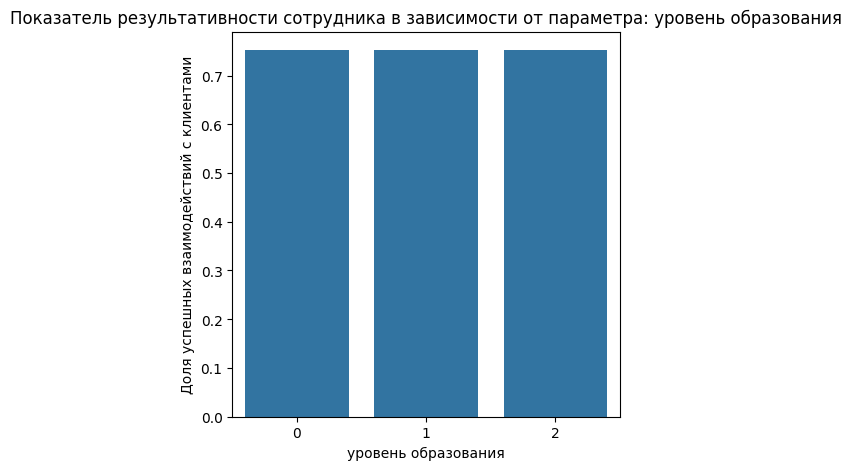

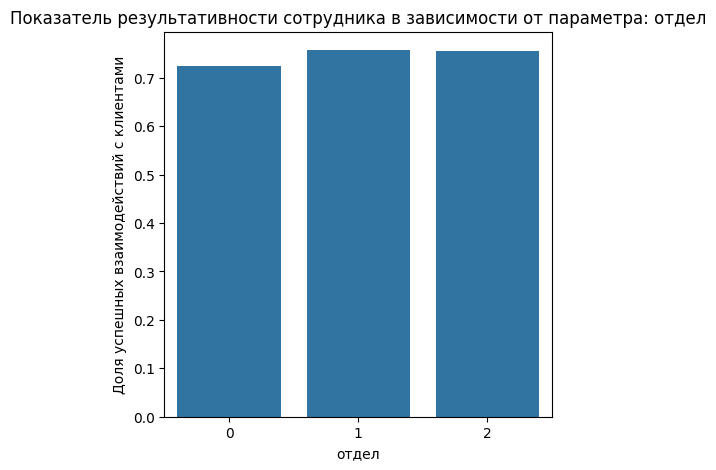

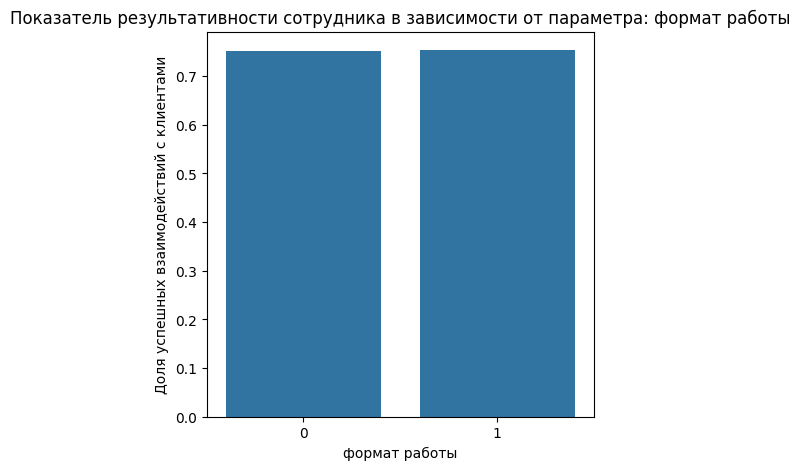

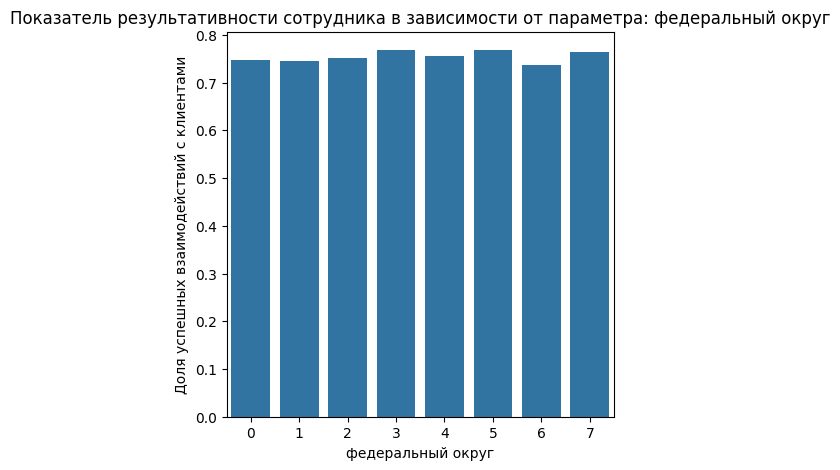

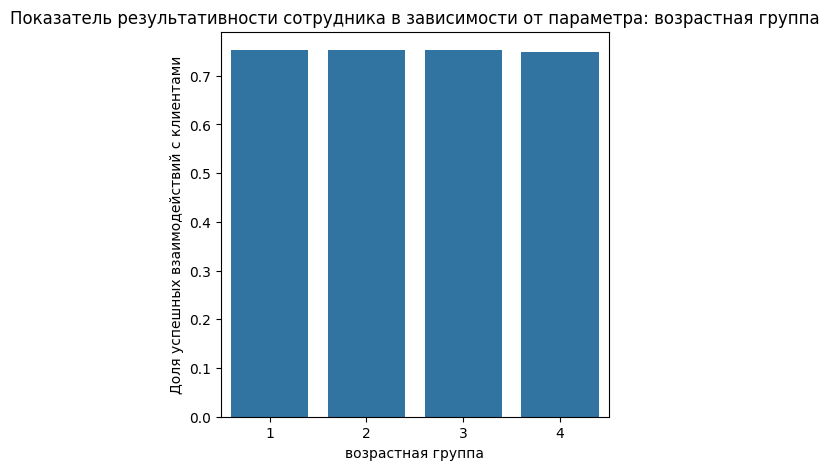

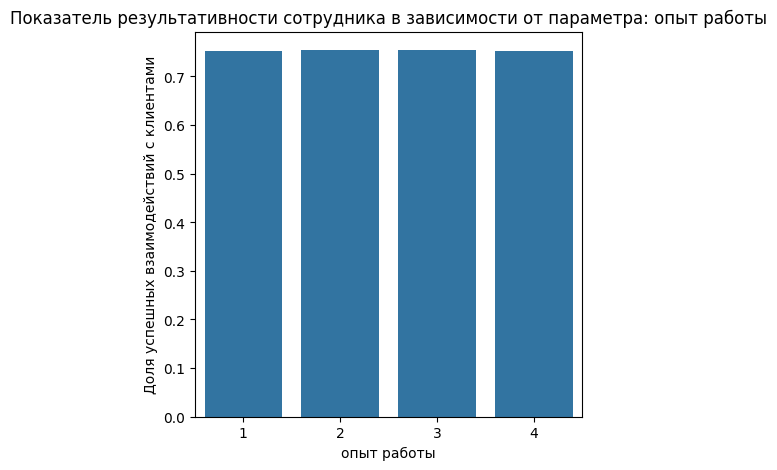

In [93]:
# Предположительно, department_id, work_online_flg, region, exp_days, age также не влияют на рабочие показатели значимо 
# (везде доля успехов примерно 0,75, что видно на полученных графиках)

for param, value in params_to_check.items():
    total, param = check_impact(param)
    plt.figure(figsize=(5, 5))
    sns.barplot(x=param, y='success_ratio', data=total)
    plt.xlabel(value)
    plt.ylabel('Доля успешных взаимодействий с клиентами')
    plt.title('Показатель результативности сотрудника в зависимости от параметра: ' + value)
    plt.show()

Анализ показателей результативности сотрудников компании в зависимости от различных параметров позволяет выявить влияние уровня образования, отдела, формата работы, федерального округа, возрастной группы и опыта работы на успешность взаимодействия с клиентами. Основываясь на предоставленных диаграммах, можно сделать следующие наблюдения:

- Уровень образования: Доля успешных взаимодействий с клиентами кажется одинаковой вне зависимости от уровня образования сотрудника.
- Отдел: Похоже, что доля успешных взаимодействий с клиентами распределена равномерно по отделам.
- Формат работы: Результаты показывают, что формат работы (удаленно или в офисе) не оказывает заметного влияния на успешность коммуникаций с клиентами.
- Федеральный округ: Результативность работы с клиентами не показывает значительных различий между разными федеральными округами.
- Возрастная группа: Результативность сотрудников кажется сопоставимой в разных возрастных группах.
- Опыт работы: Доля успешных взаимодействий с клиентами также не демонстрирует значительного изменения в зависимости от стажа работы.

**Общий вывод**:
Исходя из анализа графиков, можно предположить, что в компании существует стабильно высокий уровень взаимодействия с клиентами, который не зависит от изученных параметров. Это может указывать на эффективные корпоративные стандарты и обучение, которые обеспечивают однородность в подходах к клиентскому обслуживанию в различных отделах и регионах, среди сотрудников разного возраста и с различным уровнем образования.


In [96]:
# Построим матрицу корреляции
corr = merged.corr(numeric_only=True)
corr.style.background_gradient(cmap='coolwarm').format(precision = 2)

,communication_id,communication_score,util_flg,region,age,exp_days,edu_degree,department_id,work_online_flg
communication_id,1.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00
communication_score,0.00,1.00,0.34,-0.00,-0.01,0.01,0.00,0.00,-0.00
util_flg,-0.00,0.34,1.00,0.01,-0.00,0.00,0.00,0.02,0.00
region,-0.00,-0.00,0.01,1.00,-0.02,0.03,0.01,-0.00,-0.01
age,-0.00,-0.01,-0.00,-0.02,1.00,0.01,-0.01,0.00,0.02
exp_days,0.00,0.01,0.00,0.03,0.01,1.00,0.01,0.00,-0.01
edu_degree,0.00,0.00,0.00,0.01,-0.01,0.01,1.00,-0.02,0.05
department_id,-0.00,0.00,0.02,-0.00,0.00,0.00,-0.02,1.00,0.01
work_online_flg,0.00,-0.00,0.00,-0.01,0.02,-0.01,0.05,0.01,1.00


Корреляционная матрица также показывает отсутствие корреляций

# Итоговые выводы

По итогам предварительного анализа данных сотрудников колл-центра группы компаний Тинькофф и их участия в обучающих курсах на edTech платформе можно сделать следующие общие выводы:

1. Сотрудники колл-центра демонстрируют активное участие в образовательных программах, что указывает на заинтересованность в повышении квалификации и развитии профессиональных навыков.
   
2. Высокий уровень успешного завершения курсов свидетельствует о возможности эффективного освоения предлагаемого материала и дает основания для включения таких курсов в рекомендательную систему.

3. Наличие разнообразия в продолжительности курсов отражает гибкость образовательной программы, что позволяет сотрудникам выбирать курсы в соответствии с их потребностями и временными возможностями.

4. Данные о сотрудниках показывают разнообразие по полу, возрасту, опыту работы и образовательному уровню, что может способствовать созданию более персонализированных и эффективных образовательных траекторий.

5. Анализ не показал явно, что уровень образования, опыт работы и формат работы (онлайн или офлайн) могут оказывать влияние на успешность в работе, что важно учитывать при создании рекомендательной системы.

6. Необходимо принять во внимание результаты корреляционного анализа и временного анализа для выявления тенденций и возможных закономерностей, которые могут повлиять на рекомендации по курсам.

7. Предварительный статистический анализ и сегментация сотрудников на основе их профилей и результатов в обучении могут быть использованы для разработки алгоритмов рекомендательной системы, направленных на улучшение профессионального уровня сотрудников и, как следствие, качества обслуживания клиентов.

Итак, принимая во внимание вышеуказанные выводы и анализ, рекомендательная система должна учитывать не только популярность и успешность прохождения курсов, но и индивидуальные характеристики каждого сотрудника, их предпочтения и рабочий контекст для предложения наиболее подходящих и полезных курсов. Это позволит повысить мотивацию к обучению и его эффективность.